# 基于K-近邻的车牌号识别

## 一、案例简介

图像的智能处理一直是人工智能领域广受关注的一类技术，在人工智能落地的进程中发挥着重要作用。其中车牌号识别作为一个早期应用场景，已经融入日常生活中，为我们提供了诸多便利，在各地的停车场和出入口都能看到它的身影。车牌号识别往往分为字符划分和字符识别两个子任务，本案例我们将关注字符识别的任务.

## 二、作业说明
本次我们使用已经分割好的车牌图片作为数据集，包括数字 0-9、字母 A-Z（不包含 O 和 I）以及省份简称共 65 个类，编号从 0 到 64。数据已经分成了训练集和测试集，里面的文件夹用 label 编号命名，一个文件夹下的所有图片都属于该文件夹对应的类，每个图片都是 20 * 20 的二值化灰度图。尝试用 K-NN 的方法对分割好的字符图像进行自动识别和转化。 可以使用 sk-learn 等第三方库，不要求自己实现K-NN。

### 基础任务（80分）：
1. 数据预处理任务：将图片数据读入，标准化，将每个图像表示为一维向量，同时保留其对应的标签。这是进行模型训练之前的重要步骤。

2. 模型训练任务：使用 sklearn库的KNeighborsClassifier类，构建K-NN模型，并对训练集进行训练。

3. 模型评估任务：使用模型对测试集进行预测，然后计算模型的准确率。可以使用 sklearn库的accuracy_score函数来实现。

4. 参数分析任务：探究当K值变化时，模型在测试集上的准确率如何变化。可以绘制一个图表，显示不同K值对应的准确率。

5. 数据集大小影响任务：分析当训练集大小变化时，测试结果如何变化。可以尝试不同大小的训练集，记录并分析结果。

 

### 扩展任务（20分）：
1. 距离度量分析任务：分析在K-NN中使用不同的距离度量方式（如欧氏距离、曼哈顿距离等）对模型效果的影响。

2. 方法对比任务：对比平权K-NN与加权K-NN的预测效果，分析不同权重设置对结果的影响。平权K-NN认为所有邻居的投票权重相同，而加权K-NN则根据距离远近来确定权重，更近的邻居有更大的投票权。

3. 数据增强任务：考虑到车牌字符可能在不同的光照、角度和大小下出现，可以尝试进行数据增强，如旋转、缩放、剪切等操作，以提高模型的泛化能力。

4. 数据均衡任务：如果数据集中的各类别样本数量不平衡，可能会对K-NN的性能产生影响。可以尝试使用过采样或者欠采样的方法，来使得各类别样本数量均衡。

tips：

图片数据的特征之一是冗余性，即一张128x128的图片降维到64x64依然不影响识别，因为图像的像素矩阵中的某个像素值与周边的像素值的相关性很强，因此相差并不大。所以，可以考虑对图像数据进行降维来增加模型的训练速度和精度.

### 答案区

In [2]:
from sklearn.manifold import TSNE  # 导入t-SNE降维算法
from sklearn.metrics import accuracy_score # 导入准确率评估指标
from sklearn.decomposition import SparsePCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # 导入线性判别分析算法
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor # 导入K近邻分类器和回归器
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置绘图时使用的中文字体为SimHei
plt.rcParams['axes.unicode_minus']=False # 解决绘图时负号显示为方块的问题
from PIL import Image,ImageEnhance # 导入图像处理工具PIL库
import numpy as np
import os  # 导入操作系统工具os
import pandas as pd

In [3]:
# img = Image.open('data/train/0/4-3.jpg')  # 打开图片
# pixels = np.array(img)  # 转化为 numpy 矩阵
# pixels.shape
# print(pixels.shape)
# img  # 显示图片

In [4]:
#数据增强
def identity(root_path):   #翻转图像
    img = Image.open(root_path) 
    return img
def flip(root_path):   #翻转图像
    img = Image.open(root_path)
    filp_img = img.transpose(Image.FLIP_LEFT_RIGHT)
    return filp_img
def rotation(root_path):
    img = Image.open(root_path)
    rotation_img = img.rotate(20) #旋转角度
    return rotation_img  
def brightnessEnhancement(root_path):#亮度增强
    image = Image.open(root_path)
    enh_bri = ImageEnhance.Brightness(image)
    brightness = 1.5
    image_brightened = enh_bri.enhance(brightness)
    return image_brightened

def colorEnhancement(root_path):  #颜色增强
    image = Image.open(root_path)
    enh_col = ImageEnhance.Color(image)
    color = 1.5
    image_colored = enh_col.enhance(color)
    return image_colored


methods1=[identity,flip, rotation ]
methods2=[identity, brightnessEnhancement, colorEnhancement]
 

In [5]:
#图片文件读取函数，返回一个一维的数组
def image_to_vector(path):
    returanVec=np.zeros(400)
    img = Image.open(path)
    pixel = np.array(img)#此时为二维矩阵，将其转为一维，方便运行算法拟合
    for i in range(20):
        for j in range(20):
            returanVec[i*20+j]=pixel[i][j]
    return returanVec

In [6]:
# 定义加载数据函数，用于读取图像数据和标签
def load_data(dataset_path):
    image_list = []  # 存储图像向量的列表
    label_list = [] # 存储标签值的列表

    labels_path_list = os.listdir(dataset_path) # 获取数据集路径下的目录列表
    labels_path_list.pop(0) # 移除第一个元素，该元素为非目录，说明到达了叶子目录，里面存放着图像

    for i in range(len(labels_path_list)):
        image_label_path = dataset_path+'/'+labels_path_list[i]
        image_path_list = os.listdir(image_label_path)
        for image_path in image_path_list:
            vector=image_to_vector(image_label_path+'/'+image_path)
            image_list.append(vector)
            label_list.append(int(labels_path_list[i]))

    image_list = np.array(image_list)
    label_list = np.array(label_list)
    print("图片向量的维度:",image_list.shape , "标签值的维度:",label_list.shape)
    return image_list , label_list

X_train, y_train = load_data(dataset_path=r'D:\Code\data_s\train')
X_test, y_test = load_data(dataset_path=r'D:\Code\data_s\test')

图片向量的维度: (5321, 400) 标签值的维度: (5321,)
图片向量的维度: (3217, 400) 标签值的维度: (3217,)


In [7]:
#图片文件读取函数，返回一个一维的数组
def image_to_vector(img):
    returanVec=np.zeros(400)
    pixel = np.array(img)#此时为二维矩阵，将其转为一维，方便运行算法拟合
    for i in range(20):
        for j in range(20):
            returanVec[i*20+j]=pixel[i][j]
    return returanVec

In [8]:
#数据增强的调用
def load_data(dataset_path):
    image_list = []
    label_list = []

    labels_path_list = os.listdir(dataset_path)
    labels_path_list.pop(0)#说明到了叶子目录,里面放着就是图片

    for i in range(len(labels_path_list)):
        image_label_path = dataset_path+'/'+labels_path_list[i]
        image_path_list = os.listdir(image_label_path)
        for image_path in image_path_list:
            img_path=image_label_path+'/'+image_path
            for method in methods2:
                img=method(img_path)
                vector=image_to_vector(img)
                image_list.append(vector)
                label_list.append(int(labels_path_list[i]))

    image_list = np.array(image_list)
    label_list = np.array(label_list)
    print("图片向量的维度:",image_list.shape , "标签值的维度:",label_list.shape)
    return image_list , label_list

X_train2, y_train2 = load_data(dataset_path=r'D:\Code\data_s\train')
X_test2, y_test2 = load_data(dataset_path=r'D:\Code\data_s\test')

图片向量的维度: (15963, 400) 标签值的维度: (15963,)
图片向量的维度: (9651, 400) 标签值的维度: (9651,)


In [9]:
# 对数据进标准化预处理
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.fit_transform(X_test)

# 对数据进标准化预处理
std = StandardScaler()
X_train_std2 = std.fit_transform(X_train2)
X_test_std2 = std.fit_transform(X_test2)

In [20]:
# 选则最优参数
parameters={'n_neighbors':[1,2,3,4,5,6,7,8,9,10],
            'weights':['uniform','distance'],
            'p':[1,2],
            }
knn=KNeighborsClassifier()
grid_search=GridSearchCV(knn,parameters,scoring='accuracy',cv=5,verbose=100,n_jobs=1)
grid_search.fit(X_train_std,y_train)
label = grid_search.predict(X_test_std)
print(grid_search.best_score_,grid_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 1/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.917 total time=   0.1s
[CV 2/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 2/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.932 total time=   0.1s
[CV 3/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 3/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.907 total time=   0.1s
[CV 4/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 4/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.918 total time=   0.1s
[CV 5/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 5/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.891 total time=   0.1s
[CV 1/5; 2/40] START n_neighbors=1, p=1, weights=distance.......................
[CV 1/5; 2/4

In [11]:
#原始数据的训练精度
knn=KNeighborsClassifier(n_neighbors=1,weights='uniform',p=2)
knn.fit(X_train_std,y_train)
label = knn.predict(X_test_std)
acc=accuracy_score(y_test,label)
print(acc)

0.7559838358719304


In [12]:
#数据增强后的训练精度
knn=KNeighborsClassifier(n_neighbors=1,weights='uniform',p=2)
knn.fit(X_train_std2,y_train2)
label = knn.predict(X_test_std2)
acc=accuracy_score(y_test2,label)
print(acc)

0.7668635374572583


In [13]:
from imblearn.over_sampling import SMOTE 

oversample = SMOTE() # 定义SMOTE模型对象
X_train_smote, y_train_smote = oversample.fit_resample(X_train_std2, y_train2) # 输入数据并作过抽样处理
X_test_smote, y_test_smote = oversample.fit_resample(X_test_std2, y_test2)
print("SMOTE之后图片向量的维度:",X_train_smote.shape , "SMOTE之后标签值的维度:",y_train_smote.shape)
print("SMOTE之后图片向量的维度:",X_test_smote.shape , "SMOTE之后标签值的维度:",y_test_smote.shape)

knn=KNeighborsClassifier(n_neighbors=1,weights='uniform',p=2)
knn.fit(X_train_smote,y_train_smote)
label = knn.predict(X_test_smote)
acc=accuracy_score(y_test_smote,label)
print(acc)

SMOTE之后图片向量的维度: (19200, 400) SMOTE之后标签值的维度: (19200,)
SMOTE之后图片向量的维度: (18900, 400) SMOTE之后标签值的维度: (18900,)
0.7821164021164021


In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)

X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test_smote)

knn=KNeighborsClassifier(n_neighbors=1,weights='uniform',p=2)
knn.fit(X_train_pca,y_train_smote)
label = knn.predict(X_test_pca)
acc=accuracy_score(y_test_smote,label)
print(acc)

0.7570370370370371


In [15]:
def draw(x,y,name,title,xlabel,ylabel):
    plt.plot(x,y,label=name)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    #plt.show()

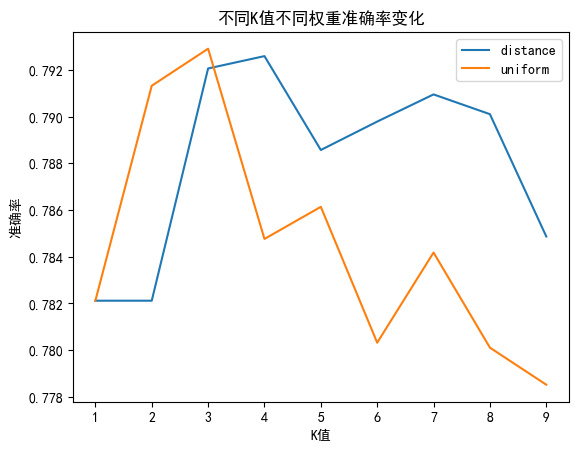

In [16]:
title='不同K值不同权重准确率变化'
xlabel='K值'
ylabel='准确率'
weight_list = ['distance','uniform']
for weight in weight_list:
    accuracy_score_list=[]
    for k in range(1,10):
        knn=KNeighborsClassifier(n_neighbors=k,weights=weight)
        knn.fit(X_train_smote,y_train_smote)
        label = knn.predict(X_test_smote)
        acc=accuracy_score(y_test_smote,label)
        accuracy_score_list.append(acc)
    draw(range(1,10),accuracy_score_list,weight,title,xlabel,ylabel)
plt.show()

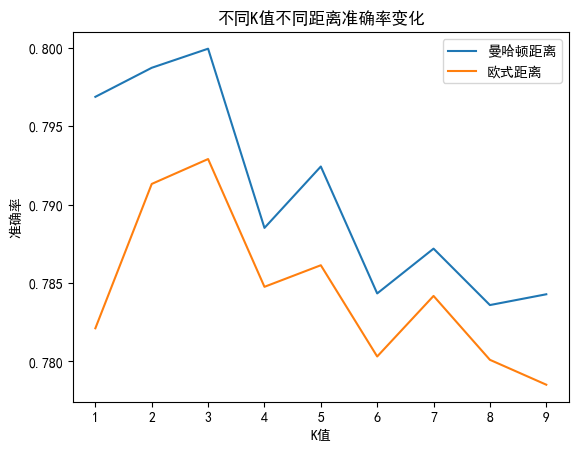

In [17]:
title='不同K值不同距离准确率变化'
xlabel='K值'
ylabel='准确率'
p_list = [1,2]
name_list=['曼哈顿距离','欧式距离','闵可夫斯基距离']
for p in p_list:
    accuracy_score_list=[]
    for k in range(1,10):
        knn=KNeighborsClassifier(n_neighbors=k,weights='uniform',p=p)
        knn.fit(X_train_smote,y_train_smote)
        label = knn.predict(X_test_smote)
        acc=accuracy_score(y_test_smote,label)
        accuracy_score_list.append(acc)
    draw(range(1,10),accuracy_score_list,name_list[p-1],title,xlabel,ylabel)

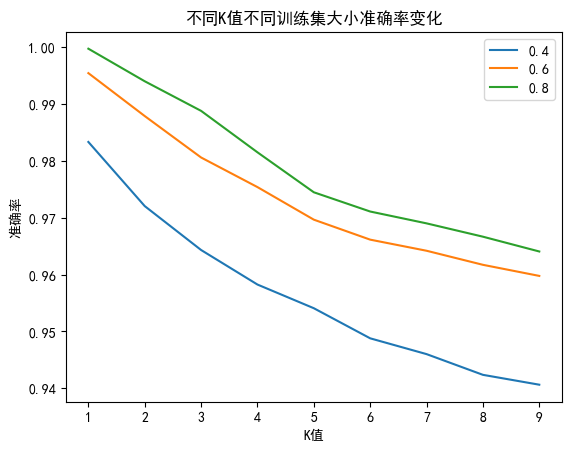

In [18]:
# 对数据进标准化处理
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.fit_transform(X_test)
#绘图
train_size_list=[0.4,0.6,0.8]
title='不同K值不同训练集大小准确率变化'
xlabel='K值'
ylabel='准确率'
for train_size in train_size_list:
    accuracy_score_list=[]
    for k in range(1,10):
        x_train, x_test , y_train_label, y_test_label=train_test_split(X_train_smote,y_train_smote,train_size=train_size,random_state=42)
        knn=KNeighborsClassifier(n_neighbors=k,weights='uniform',p=1)
        knn.fit(x_train,y_train_label)
        label = knn.predict(x_test)
        acc=accuracy_score(label,y_test_label)
        accuracy_score_list.append(acc)
    draw(range(1,10),accuracy_score_list,train_size,title,xlabel,ylabel)